In [3]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas as dg
dg.set_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Plotting preliminaries
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
pastel_rainbow = np.array([
    [0.17254902, 0.45098039, 0.69803922],
    [0.19607843, 0.47843137, 0.5372549 ],
    [0.16862745, 0.20392157, 0.48627451],
    [0.24705882, 0.58039216, 0.42745098],
    [0.65882353, 0.75294118, 0.86666667],
    [0.63921569, 0.85490196, 0.52156863],
    [0.72941176, 0.67843137, 0.83921569],
    [0.53333333, 0.62352941, 0.47843137],
    [0.64705882, 0.70588235, 0.52156863],
    [0.64313725, 0.14117647, 0.48627451],
    [0.92941176, 0.61568627, 0.24705882],
    [0.86666667, 0.23137255, 0.20784314]
])

# Tune hyperparameters

In [49]:
%%bash

# python3 find_hyperparameters.py

Process is terminated.


# Run and record forecasts on test data

In [73]:
%%bash --out output --err error

# python3 compute_benchmarks.py

Process is terminated.


## Load Univariate Forecasting Benchmark Results

In [3]:
import os
import json

GRANULARITY = 100

with open(
    os.getcwd()
    + "/results/results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12.json",
    "r",
) as file:
    all_results = json.load(file)

# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)


## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)


from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")


all_metric_names = list(all_results_transposed["ARIMA"]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

### Load mathematical properties

In [4]:
import dysts.flows

max_lyap = list()
best_scores = list()
for equation_name in all_results:
    
    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


### Correlate forecasting models

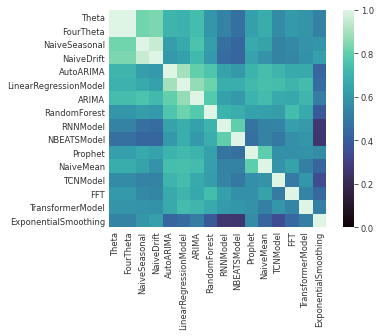

In [5]:
model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name ] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])
df_models = pd.DataFrame(model_records)


corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

# df_models_sorted = df_models.iloc[:, sort_order]

ax = sns.heatmap(df_models_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/model_correlation_map.png", dpi=600)

### Compare forecasting metrics

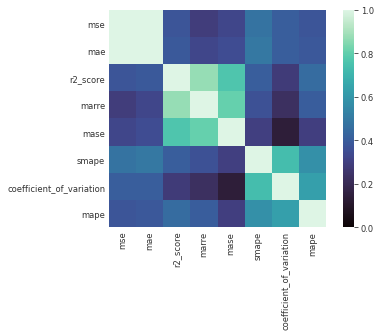

In [32]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]


ax = sns.heatmap(df_metrics_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_map.png", dpi=600)

### Compare forecasting results against mathematical properties

In [3]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_results[equation_name]["ARIMA"]:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["NBEATSModel"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [4]:
import dysts.flows

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose().dropna()

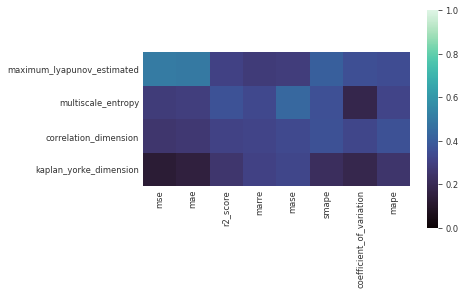

In [55]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_math.png", dpi=600)

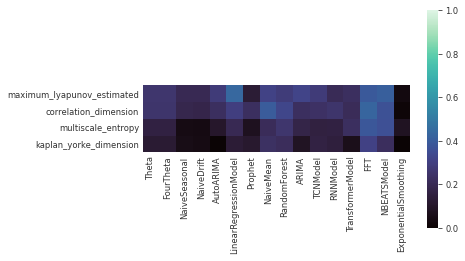

In [246]:
cross_corr = pd.concat([models_df, all_properties], axis=1, keys=['models_df', 'all_properties']).corr(method="spearman").loc['models_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds][df_models_sorted.columns], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/models_math_corr.png", dpi=600)

In [81]:

## Easiest and hardest systems
print("Easiest systems: ", np.unique(models_df.idxmin(axis=0), return_counts=True))
print("Hardest systems: ", np.unique(models_df.idxmax(axis=0), return_counts=True))


all_median_names = list()
for key in models_df.keys():
    all_median_names.append(models_df[models_df[key] == models_df[key].quantile(interpolation='nearest')].index[0])
    
print("Middle systems: ", np.unique(all_median_names, return_counts=True))

Easiest systems:  (array(['ArnoldWeb', 'StickSlipOscillator', 'Torus'], dtype=object), array([ 1,  5, 10]))
Hardest systems:  (array(['CellularNeuralNetwork', 'Chua', 'CoevolvingPredatorPrey',
       'DoublePendulum', 'HyperQi', 'LuChen', 'SprottTorus',
       'TurchinHanski'], dtype=object), array([2, 1, 2, 1, 2, 1, 6, 1]))
Middle systems:  (array(['ChenLee', 'Duffing', 'Finance', 'Halvorsen', 'HyperYan',
       'JerkCircuit', 'LorenzStenflo', 'OscillatingFlow', 'Rossler',
       'Rucklidge', 'SprottA', 'SprottF', 'SprottG', 'ThomasLabyrinth'],
      dtype='<U15'), array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]))


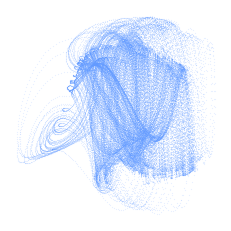

In [39]:
plt.figure()
sol = Hadley().make_trajectory(80000, resample=True, pts_per_period=100)
plt.plot(sol[:, 0], sol[:, 2], ".", color=dg.blue, markersize=0.1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/lorenz.png", dpi=600)


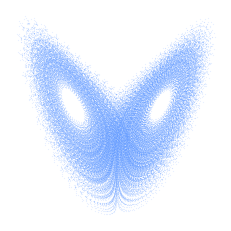

In [38]:
plt.figure()
sol = Lorenz().make_trajectory(80000, resample=True, pts_per_period=100)
plt.plot(sol[:, 0], sol[:, 2], ".", color=dg.blue, markersize=0.1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/lorenz.png", dpi=600)


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


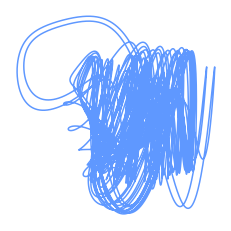

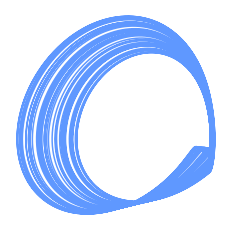

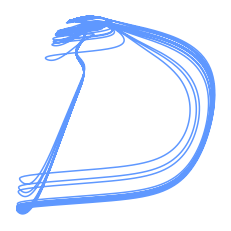

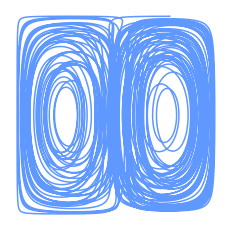

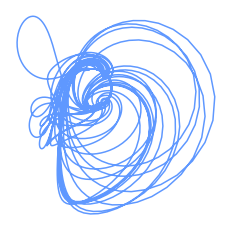

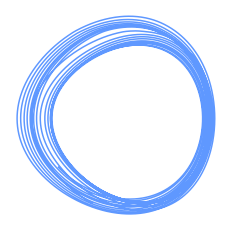

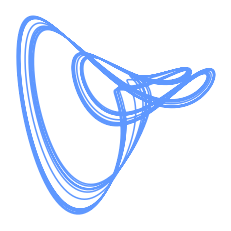

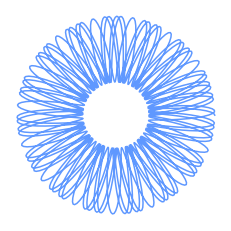

In [22]:
from dysts.flows import SprottTorus, StickSlipOscillator, Torus, SprottG

style1 = {"color": (0.4, 0.4, 0.4)}

style1 = {"color": dg.blue}

plt.figure()
sol = Hadley().make_trajectory(40000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/hadley2.png", dpi=600)

plt.figure()
sol = WindmiReduced().make_trajectory(20000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/windmi2.png", dpi=600)


plt.figure()
sol = HindmarshRose().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/hindmarsh2.png", dpi=600)


plt.figure()
sol = DoubleGyre().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/gyre2.png", dpi=600)

plt.figure()
sol = SprottTorus().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprott_torus2.png", dpi=600)

plt.figure()
sol = StickSlipOscillator().make_trajectory(20000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/stickslip2.png", dpi=600)

plt.figure()
sol = SprottG().make_trajectory(10000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprottg2.png", dpi=600)

plt.figure()
sol = Torus().make_trajectory(2000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/torus2.png", dpi=600)

### Compare different forecasting models

In [67]:
import pandas as pd

def mirror_df(df, mirror_val=0):
    """
    Create a mirrored augmented dataframe. Used
    for setting the right boundary conditions on kernel 
    density plots
    """
    if np.isscalar(mirror_val):
        return pd.concat([df, mirror_val - df])
    else:
        all_out_df = [df]
        for val in mirror_val:
            all_out_df.append(val - df)
        return pd.concat(all_out_df)
    
dflo = pd.DataFrame.from_dict(hist_values_low)
dflo["Granularity"] = "Coarse"

dfhi = pd.DataFrame.from_dict(hist_values_high)
dfhi["Granularity"] = "Fine"
data = pd.merge(dflo, dfhi, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
sort_order = np.argsort(all_medians)

data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")

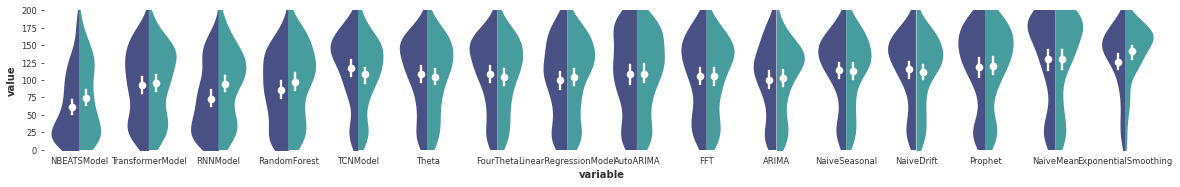

In [72]:
plt.figure(figsize=(20, 10))
ax = plt.gca()


ax = sns.violinplot(
    data=data_long,
    x="variable",
    y="value",
    hue="Granularity",
    order=all_model_names[sort_order],
    linewidth=0,
    size=3,
    alpha=0.1,
    split=True,
    scale="area",
    inner=None,
    palette="mako",
)
ax = sns.pointplot(
    data=data_long,
    x="variable",
    y="value",
    hue="Granularity",
    order=all_model_names[sort_order],
    linewidth=0,
    size=4,
    palette={"Coarse": "w", "Fine": "w"},
    join=False,
    ci=99,
    dodge=0.2,
)


plt.ylim([0, 200])
dg.fixed_aspect_ratio(1 / 8)
ax.grid(False)
ax.legend_.remove()

# dg.better_savefig("../private_writing/fig_resources/forecasting_violins.png", dpi=600)

## Group models by mathematical properties

In [212]:
equation_names = list(all_results.keys())
model_names = list(all_results[equation_names[0]].keys())
model_names.remove("values")
score_names = list(all_results[equation_names[0]][model_names[0]].keys())
score_names.remove("prediction")

results_reduced = dict()
for equation_name in equation_names:
    results_reduced[equation_name] = dict()
    for model_name in model_names:
        val = all_results[equation_name][model_name]["smape"]
        results_reduced[equation_name][model_name] = val 
results_reduced = pd.DataFrame.from_dict(results_reduced)     
results_reduced = results_reduced.iloc[sort_order] # sort by median error

Text(0.5, 1.0, 'Show legend')

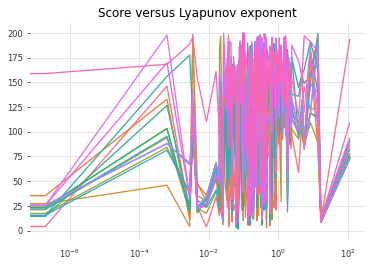

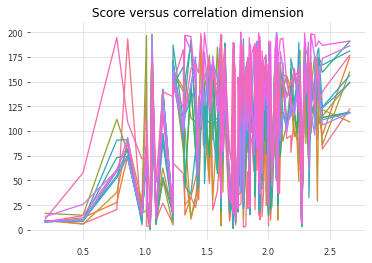

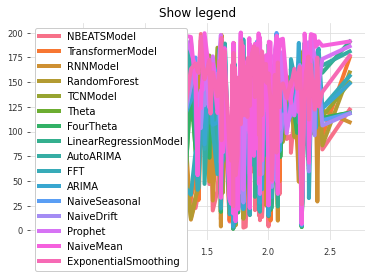

In [213]:
sort_inds = all_properties.sort_values(by="maximum_lyapunov_estimated").index

color_list = sns.color_palette("husl", results_reduced.shape[0])

plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.semilogx(
        all_properties["maximum_lyapunov_estimated"][sort_inds],
        row,
        color=clr
    )
plt.title("Score versus Lyapunov exponent")




sort_inds = all_properties.sort_values(by="correlation_dimension").index

plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr
    )
plt.title("Score versus correlation dimension")


plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr,
        linewidth=4
    )
plt.legend(results_reduced.index, facecolor='white', framealpha=1, frameon=True)
plt.title("Show legend")

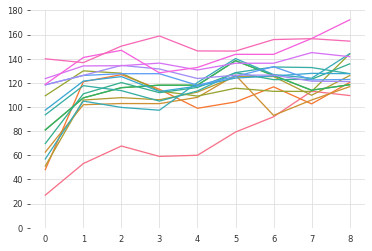

In [242]:
prop_name = "correlation_dimension"
prop_name = "maximum_lyapunov_estimated"
prop_name = "multiscale_entropy"

all_vals = list()
vals = np.array(all_properties[prop_name])

all_windows = list(zip(10 * np.arange(9), 10 * np.arange(2, 11)))

for window in all_windows:
    sel_inds = all_properties[prop_name][
        all_properties[prop_name].between(
            np.percentile(vals, window[0]), np.percentile(vals, window[1])
        )
    ].index
    all_vals.append(results_reduced[sel_inds].median(axis=1))
    
plt.figure()
for clr, row in zip(color_list, np.array(all_vals).T):
    plt.plot(row, color=clr)
plt.ylim([0, 180])
dg.better_savefig("../private_writing/fig_resources/" + prop_name + "_ranks.png", dpi=600)

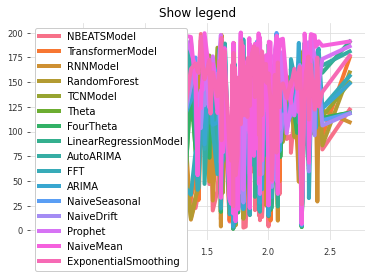

In [238]:

    
plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr,
        linewidth=4
#     )
plt.legend(results_reduced.index, facecolor='white', framealpha=1, frameon=True)
plt.title("Show legend")

# dg.better_savefig("../private_writing/fig_resources/lyap_legend.png", dpi=600)



# Multivariate benchmarks

+ Added in 2023

In [7]:
import os
import json

GRANULARITY = 100

with open(
    os.getcwd()
    + "/results/results_neural_ode_multivariate.json",
    "r",
) as file:
    all_results2 = json.load(file)

with open(
    os.getcwd()
    + "/results/results_test_multivariate__pts_per_period_100__periods_12.json",
    "r",
) as file:
    all_results1 = json.load(file)

all_scores = dict()
for key in all_results1.keys():
    if key not in all_results2.keys():
        continue
    all_scores[key] = dict()
    for model_name in all_results1[key].keys():
        if model_name == "values":
            continue
        all_scores[key][model_name] = all_results1[key][model_name]["smape"]
    all_scores[key]["nODE"] = all_results2[key]["smape"]

all_scores = pd.DataFrame(all_scores).transpose()

print(all_scores.shape)

(131, 13)


NBEATSModel               56.462485
NHiTSModel                62.933582
RandomForest              70.518979
RNNModel                  71.045973
nODE                      75.584701
TransformerModel          77.053306
XGBModel                  86.580253
LinearRegressionModel     86.692339
NLinearModel              90.487595
DLinearModel              95.192333
BlockRNNModel            103.323261
TCNModel                 113.761830
KalmanForecaster         130.020557
dtype: float64

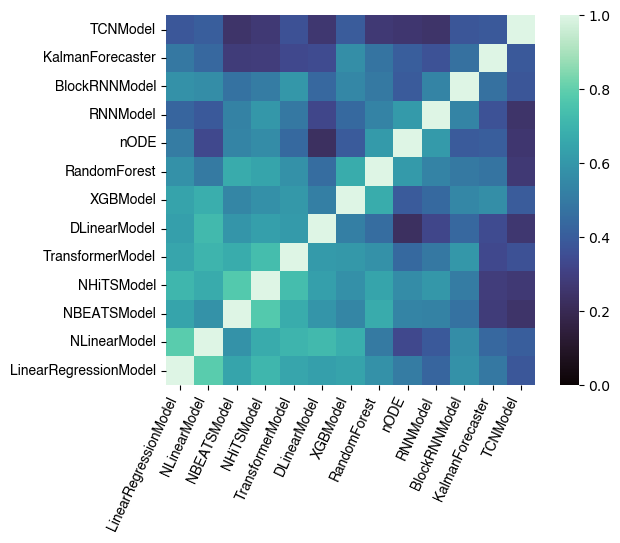

In [8]:
# plt.imshow(all_scores.corr(), vmin=0, vmax=1)
import seaborn as sns

## Sort the models by their correlation with the best model
corr_array = np.array(all_scores.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)
sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
all_scores = all_scores.iloc[:, sort_inds]
ax = sns.heatmap(all_scores.corr(method='spearman'), cmap="mako", vmin=0, vmax=1, square=True)
ax.invert_yaxis()
## tilt the x labels and center on tick
for item in ax.get_xticklabels():
    item.set_rotation(65)
    item.set_horizontalalignment("right")

# set font to helvetica
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')



# Best model on average
all_scores.mean(axis=0).sort_values()


Text(0.5, 1.0, 'Spearman correlation = 0.43')

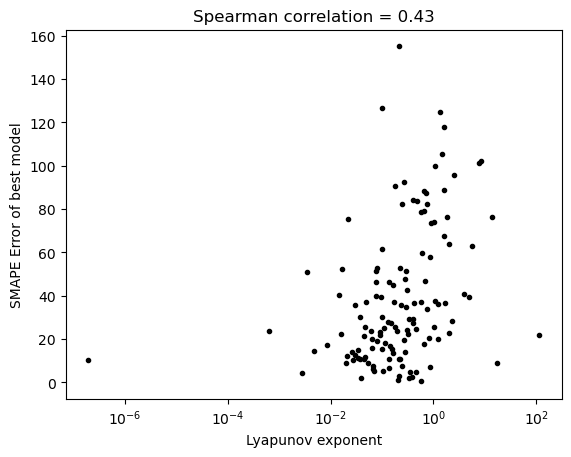

In [9]:
# best_scores = pd.DataFrame(all_scores["NBEATSModel"])
best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

# add column for lyapunov exponents
best_scores["lyapunov"] = np.nan * np.ones(best_scores.shape[0])

import dysts.flows as dfl

for equation_name in best_scores.index:
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    best_scores.loc[equation_name, "lyapunov"] = max_lyap

plt.figure()
plt.semilogx(best_scores["lyapunov"], best_scores.iloc[:, 0], '.k')
plt.xlabel("Lyapunov exponent")
plt.ylabel("SMAPE Error of best model")

from scipy.stats import spearmanr
corr_val = spearmanr(best_scores["lyapunov"], best_scores.iloc[:, 0])[0]
plt.title(f"Spearman correlation = {corr_val:.2f}")


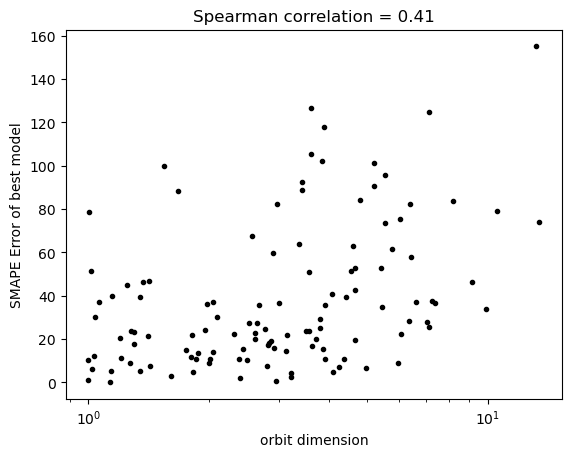

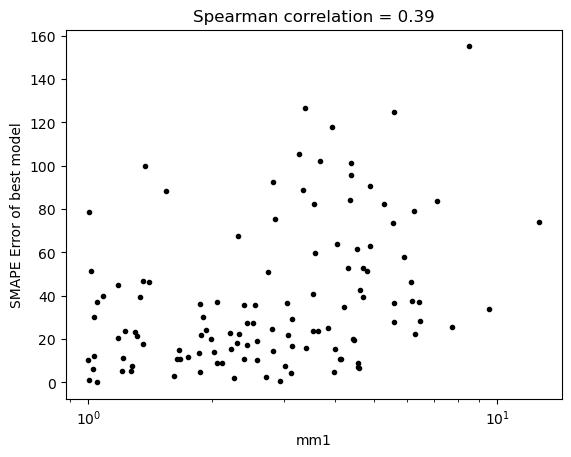

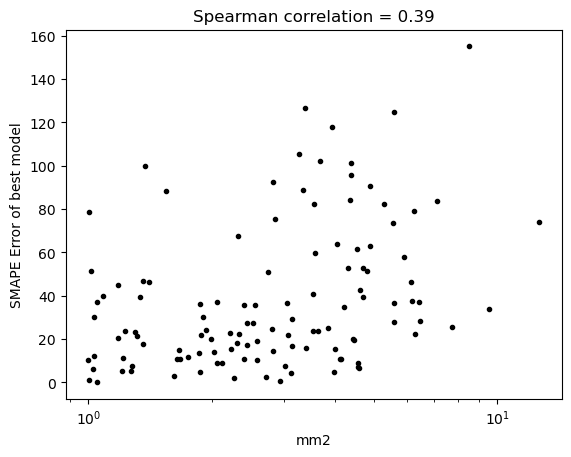

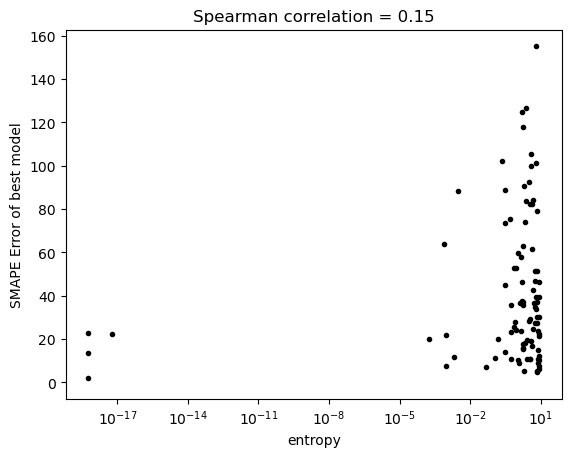

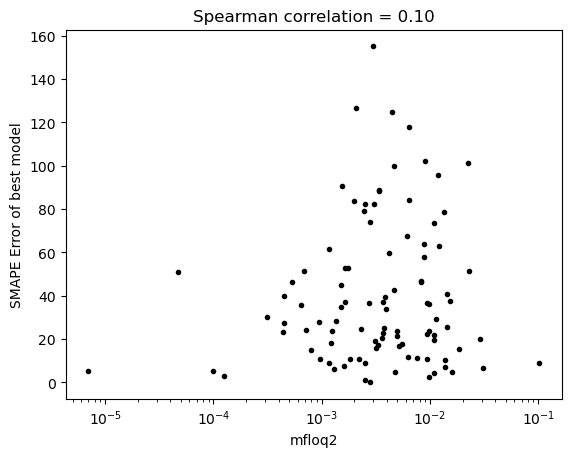

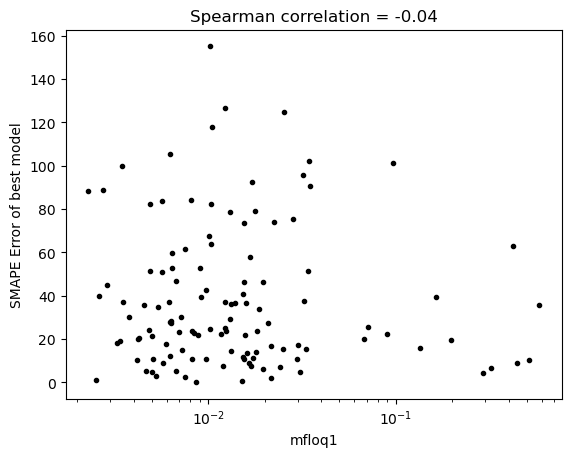

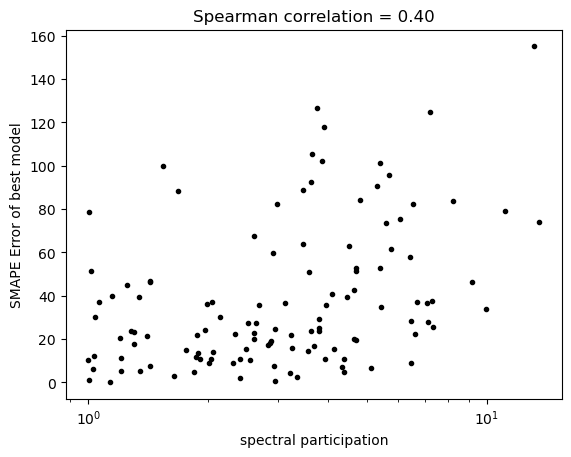

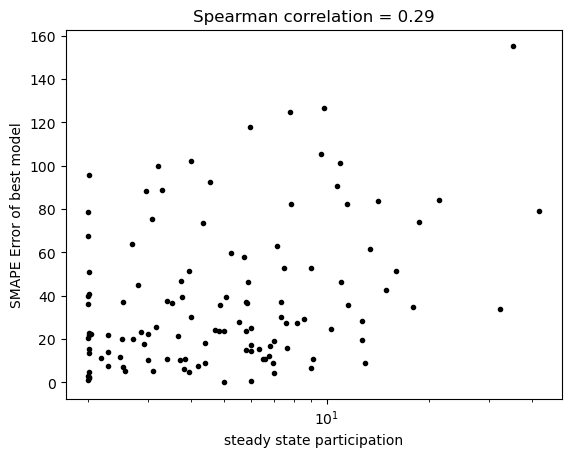

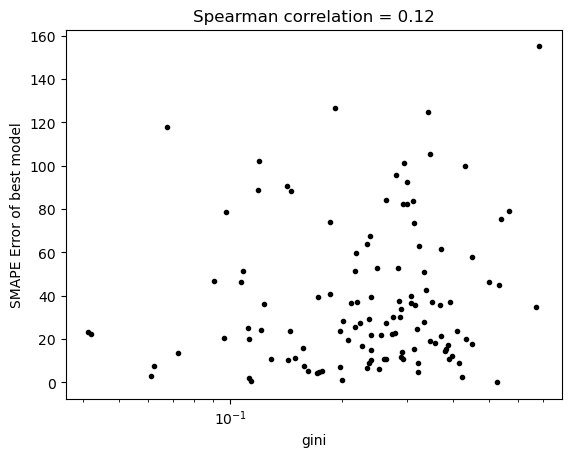

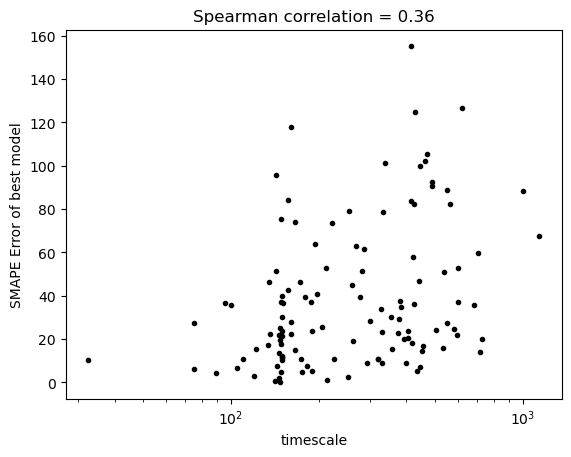

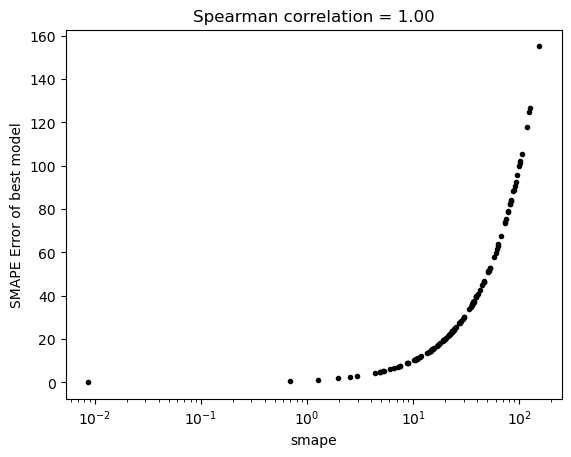

In [32]:
import pandas as pd
orbit_features = pd.read_csv("./resources/private_topo_features.csv", index_col=0)

best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

## Merge the two dataframes
best_scores = orbit_features.merge(best_scores, left_index=True, right_index=True)
best_scores = best_scores.dropna()


for name in best_scores.columns:

    plt.figure()
    plt.semilogx(best_scores[name], best_scores["smape"], '.k')
    plt.xlabel(name)
    plt.ylabel("SMAPE Error of best model")

    from scipy.stats import spearmanr
    corr_val = spearmanr(best_scores[name], best_scores["smape"])[0]
    plt.title(f"Spearman correlation = {corr_val:.2f}")

## Long forecast task

+ TO DO: add echo-state networks: https://github.com/reservoirpy/reservoirpy

In [20]:
for key in all_results.keys():
    if key not in all_results_node[key].keys():
        continue
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]

In [18]:
all_results["Aizawa"].keys()

dict_keys(['values', 'RNNModel', 'RandomForest', 'NLinearModel', 'KalmanForecaster', 'DLinearModel', 'BlockRNNModel', 'XGBModel', 'LinearRegressionModel', 'NHiTSModel', 'NBEATSModel', 'TCNModel', 'TransformerModel'])

In [21]:
## Compute smape versus forecast horizon

import gzip

from dysts.metrics import smape
import dysts.flows as dfl
import json

## Load data from long forecasting task
# with open(
#     os.getcwd()
#     + "/results/results_test_multivariate__pts_per_period_100__periods_60.json",
#     "r",
# ) as file:
#     all_results = json.load(file)

## Load data from long forecasting task
fpath = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_60.json.gz"
all_results = gzip.open(fpath, mode='r').read()
all_results = json.loads(all_results)

## Load and append neural ode results
fpath = os.getcwd() + "/results/results_neural_ode_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_node = gzip.open(fpath, mode='r').read()
all_results_node = json.loads(all_results_node)
for key in all_results.keys():
    if key not in all_results_node[key].keys():
        continue
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]


all_outputs = dict()
for key in all_results:
    true_vals = np.array(all_results[key]["values"])
    all_traces = dict()
    for key2 in all_results[key]:
        if key2 == "values":
            continue

        pred_vals = np.array(all_results[key][key2]["prediction"])

        ## Some models fail to generate forecasts
        if np.any(pred_vals == None):
            continue
        
        ## probably need to exclude the maximum lookback window, since some models
        ## just learn a difference operator
        all_smapes = []
        for i in range(1, pred_vals.shape[0]):
            true_vals_sub = true_vals[:i, :]
            pred_vals_sub = pred_vals[:i, :]
            smape_val = smape(true_vals_sub, pred_vals_sub)
            all_smapes.append(smape_val)
        all_traces[key2] = np.array(all_smapes)
    #all_traces = np.array(all_traces)
    all_outputs[key] = all_traces
    #all_outputs.append(all_traces)

    #all_outputs[key] = all_traces
    # all_output_scores[key] = dict()
    # all_output_scores[key]["mean"] = np.mean(all_traces, axis=0)
    # all_output_scores[key]["median"] = np.median(all_traces, axis=0)
    # all_output_scores[key]["min"] = np.min(all_traces, axis=0)

    # np.mean(np.array(all_traces), axis=0)
    # np.median(np.array(all_traces), axis=0)
    # np.min(np.array(all_traces), axis=0)


## Fetch all lyapunov exponents
all_lyaps = dict()
for equation_name in all_results.keys():
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    all_lyaps[equation_name] = max_lyap
    


## Trim dangling values from incomplete HPC jobs
# all_outputs = np.array(all_outputs[:-1])
# all_lyaps = all_lyaps[:-1]

print(f"{len(all_lyaps)} systems")


/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/metrics.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 100 * np.mean(np.abs(x - y) / (np.abs(x) + np.abs(y))) * 2


133 systems


In [ ]:
# save all outputs using json.dump
with open('all_outputs.json', 'w') as fp:
    json.dump(all_outputs, fp)

In [74]:
from scipy.stats import median_abs_deviation
all_smape_series = dict()
for model_name in all_outputs["Lorenz"].keys():
    all_smapes = []
    for equation_name in all_outputs.keys():
        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name}")
            continue
        smape_val = all_outputs[equation_name][model_name]
        all_smapes.append(smape_val)
    all_smapes = np.array(all_smapes)

    all_smape_series[model_name] = dict()
    all_smape_series[model_name]["median"] = np.nanmedian(all_smapes, axis=0)
    all_smape_series[model_name]["p75"] = np.percentile(all_smapes, 75, axis=0)
    all_smape_series[model_name]["p25"] = np.percentile(all_smapes, 25, axis=0)
    all_smape_series[model_name]["mad"] = median_abs_deviation(all_smapes, axis=0)
    all_smape_series[model_name]["mean"] = np.nanmean(all_smapes, axis=0)
    all_smape_series[model_name]["stderr"] = np.nanstd(all_smapes, axis=0) / np.sqrt(all_smapes.shape[0])


skipping LinearRegressionModel


In [177]:
np.mean(all_smape_series_ranked, axis=1)

array([104.22682387, 100.70521957, 122.21642851, 150.75984069,
       137.88088947, 113.32126454, 105.10599962, 105.69978598,
       103.98670982,  94.43934873, 139.29824109, 103.83883617])

In [197]:
all_smape_series_ranked[:, -14]


array([ 9,  1,  6, 11,  0,  7,  5,  8,  2, 10,  4,  3])

In [202]:
np.argsort(all_smape_series_ranked[:, -14])

array([ 9,  1,  6, 11,  0,  7,  5,  8,  2, 10,  4,  3])

In [199]:
all_smape_series_ranked[:, -14]

array([112.39924422, 108.23779793, 136.4264738 , 162.98858443,
       153.75398067, 117.61360614, 110.09841906, 113.3537383 ,
       118.47882981, 106.31783793, 148.1702321 , 110.66314692])

In [196]:
np.median(all_smape_series_ranked, axis=1)

array([ 9.,  1.,  6., 11.,  0.,  7.,  7.,  5.,  2., 10.,  4.,  3.])

In [ ]:
# all_smape_series_ranked = np.argsort(all_smape_series_ranked, axis=0)

In [203]:
model_names = list(all_smape_series.keys())
all_smape_series_ranked = list()
for model_name in model_names:
    print(model_name)
    all_smape_series_ranked.append(all_smape_series[model_name]["mean"])
all_smape_series_ranked = np.array(all_smape_series_ranked)
all_smape_series_ranked = all_smape_series_ranked.argsort(axis=0).argsort(axis=0)
model_ranking = np.argsort(np.median(all_smape_series_ranked, axis=1))
model_names = np.array(model_names)[model_ranking]

RNNModel
RandomForest
NLinearModel
KalmanForecaster
DLinearModel
BlockRNNModel
XGBModel
LinearRegressionModel
NHiTSModel
NBEATSModel
TCNModel
TransformerModel


In [211]:
pastel_rainbow 

array([[0.17254902, 0.45098039, 0.69803922],
       [0.19607843, 0.47843137, 0.5372549 ],
       [0.16862745, 0.20392157, 0.48627451],
       [0.24705882, 0.58039216, 0.42745098],
       [0.65882353, 0.75294118, 0.86666667],
       [0.63921569, 0.85490196, 0.52156863],
       [0.72941176, 0.67843137, 0.83921569],
       [0.53333333, 0.62352941, 0.47843137],
       [0.64705882, 0.70588235, 0.52156863],
       [0.64313725, 0.14117647, 0.48627451],
       [0.92941176, 0.61568627, 0.24705882],
       [0.86666667, 0.23137255, 0.20784314]])

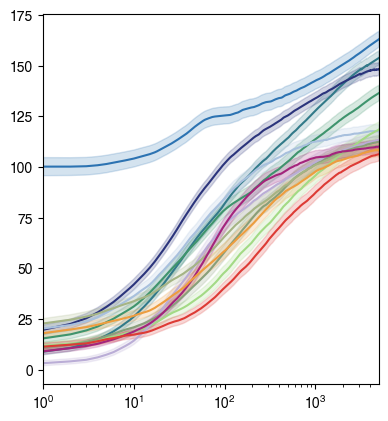

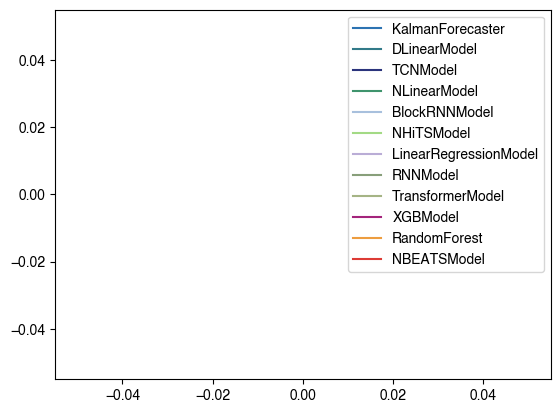

In [212]:



## rank all forecasting models in order of error
model_names = list(all_smape_series.keys())
all_smape_series_ranked = list()
for model_name in model_names:
    all_smape_series_ranked.append(all_smape_series[model_name]["mean"])
all_smape_series_ranked = np.array(all_smape_series_ranked)
all_smape_series_ranked = all_smape_series_ranked.argsort(axis=0).argsort(axis=0)
model_ranking = np.argsort(np.median(all_smape_series_ranked, axis=1))[::-1]
model_names = np.array(model_names)[model_ranking]

## Plot all models mean and errors
for i, model_name in enumerate(model_names):
    plt.semilogx(all_smape_series[model_name]["mean"], color=pastel_rainbow[i])
    plt.fill_between(
        np.arange(all_smape_series[model_name]["mean"].shape[0]),
        all_smape_series[model_name]["mean"] - all_smape_series[model_name]["stderr"],
        all_smape_series[model_name]["mean"] + all_smape_series[model_name]["stderr"],
        color=pastel_rainbow[i],
        alpha=0.2,
    )

## Square aspect ratio with logaritmic x-axis
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")
## tight xlim bounds to avoid white space
plt.xlim(1, all_smape_series[model_name]["mean"].shape[0])
## save the figure
plt.savefig(
    f"../private_writing2/fig_resources/forecast_lengths_legend.png", 
    dpi=300, 
    bbox_inches="tight"
)

## make a separate legend for the fill_between
plt.figure()
for i, model_name in enumerate(model_names):
    plt.plot([], color=pastel_rainbow[i], label=model_name)
plt.legend()
## save the figure
plt.savefig(
    f"../private_writing2/fig_resources/forecast_lengths_legend.png", 
    dpi=300, 
    bbox_inches="tight"
)



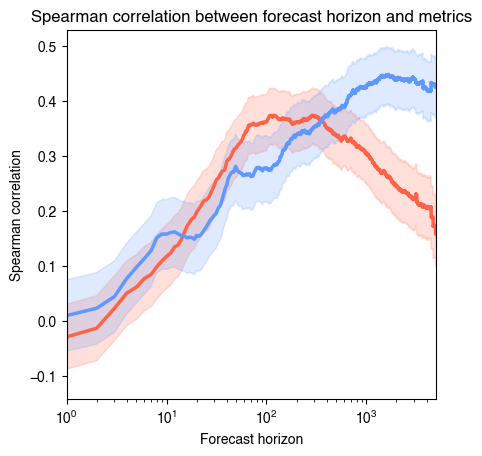

In [210]:
## try median aggregation as well

## aggregation across models
all_outputs_aggregated = dict()
for equation_name in all_results.keys():
    all_traces = list()
    for model_name in all_outputs[equation_name]:
        all_traces.append(all_outputs[equation_name][model_name])
    all_traces = np.array(all_traces)
    # all_traces = np.min(all_traces, axis=0)
    all_traces = np.mean(all_traces, axis=0)
    all_outputs_aggregated[equation_name] = all_traces


## Look up properties for each system and then correlate with the score
from scipy.stats import spearmanr
all_spearman = list()
for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
    all_spearman_sub, all_lyap_sub = list(), list()
    for equation_name in all_outputs_aggregated.keys():
        if equation_name not in all_lyaps.keys():
            continue
        lyap_val = all_lyaps[equation_name]
        score_val = all_outputs_aggregated[equation_name][i]
        all_spearman_sub.append(score_val)
        all_lyap_sub.append(lyap_val)
    corr_val = spearmanr(all_lyap_sub, all_spearman_sub)[0]
    all_spearman.append(corr_val)


## Look up properties for each system and then correlate with the score
import pandas as pd
from scipy.stats import spearmanr
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)
orbit_features = orbit_features.transpose().to_dict()
## add lyapunov exponents
for equation_name in orbit_features:
    if equation_name in all_lyaps:
        orbit_features[equation_name]["lyapunov exponent"] = all_lyaps[equation_name]


plt.figure()
correlation_dict = dict()
# for metric_name in orbit_features["Aizawa"].keys():
for metric_name in ["lyapunov exponent", "steady state participation"]:

    all_spearman = list()
    all_spearman_std = list()
    for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
        all_spearman_sub, all_metric_sub = list(), list()
        for equation_name in all_outputs_aggregated.keys():
            if equation_name not in orbit_features.keys():
                continue
            metric_val = orbit_features[equation_name][metric_name]
            if np.isnan(metric_val):
                continue
            if metric_val == None:
                continue
            score_val = all_outputs_aggregated[equation_name][i]
            all_spearman_sub.append(score_val)
            all_metric_sub.append(metric_val)
        if len(all_spearman_sub) < int(0.7 * len(orbit_features)):
            print("Excessive missing values")
        corr_val = spearmanr(all_metric_sub, all_spearman_sub, nan_policy='omit')[0]
        all_spearman.append(corr_val)

        ## confidence interval via Fisher transformation 
        corr_err_up = np.tanh(np.arctanh(corr_val) + 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        corr_err_down = np.tanh(np.arctanh(corr_val) - 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        all_spearman_std.append([corr_err_down, corr_err_up])

    all_spearman = np.array(all_spearman)
    all_spearman_std = np.array(all_spearman_std)
    correlation_dict[metric_name] = dict()
    correlation_dict[metric_name]["spearman"] = all_spearman
    correlation_dict[metric_name]["spearman interval"] = all_spearman_std

red = [1.0, 0.3882, 0.2784]
blue = [0.372549, 0.596078, 1]
colors = [red, blue]
for i, metric_name in enumerate(correlation_dict.keys()):
    all_spearman = correlation_dict[metric_name]["spearman"]
    all_sperr = correlation_dict[metric_name]["spearman interval"]
    plt.semilogx(all_spearman, color=colors[i], linewidth=2.5)
    plt.fill_between(
        np.arange(len(all_spearman)),
        all_sperr[:, 0],
        all_sperr[:, 1],
        alpha=0.2,
        color=colors[i]
    )

# plt.legend(correlation_dict.keys())
plt.xlim([1, len(all_spearman)])
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")

plt.xlabel("Forecast horizon")
plt.ylabel("Spearman correlation")
plt.title(f"Spearman correlation between forecast horizon and metrics")
plt.savefig(
    f"../private_writing2/fig_resources/forecast_horizon_correlation.png", 
    dpi=300, 
    bbox_inches="tight"
)




